based on https://github.com/clabrugere/pytorch-scarf

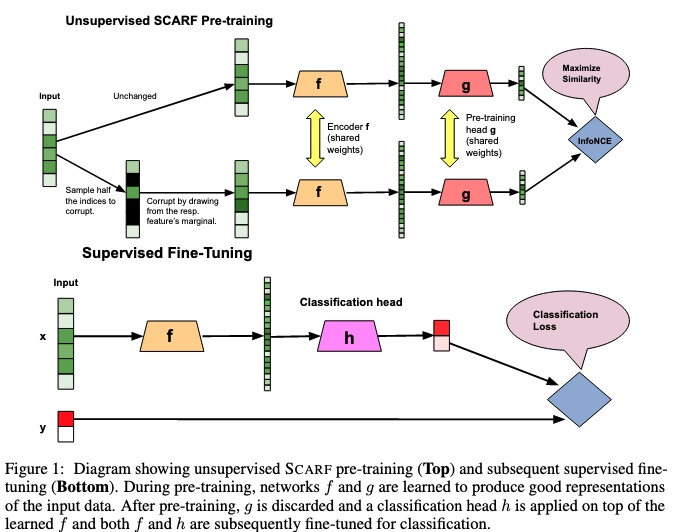

In [9]:
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# main functions

In [2]:
class ExampleDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    def __getitem__(self, index):
        # the dataset must return a pair of samples: the anchor and a random one from the
        # dataset that will be used to corrupt the anchor
        random_idx = np.random.randint(0, len(self))
        random_sample = torch.tensor(self.data[random_idx], dtype=torch.float)
        sample = torch.tensor(self.data[index], dtype=torch.float)

        return sample, random_sample

    def __len__(self):
        return len(self.data)

    def to_dataframe(self):
        return pd.DataFrame(self.data, columns=self.columns)

    @property
    def shape(self):
        return self.data.shape


In [4]:
def train_epoch(model, criterion, train_loader, optimizer, device, epoch):
    model.train()
    epoch_loss = 0.0
    batch = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    for anchor, positive in batch:
        anchor, positive = anchor.to(device), positive.to(device)

        # reset gradients
        optimizer.zero_grad()

        # get embeddings
        emb_anchor, emb_positive = model(anchor, positive)

        # compute loss
        loss = criterion(emb_anchor, emb_positive)
        loss.backward()

        # update model weights
        optimizer.step()

        # log progress
        epoch_loss += anchor.size(0) * loss.item()
        batch.set_postfix({"loss": loss.item()})

    return epoch_loss / len(train_loader.dataset)

In [5]:
def dataset_embeddings(model, loader, device):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for anchor, _ in tqdm(loader):
            anchor = anchor.to(device)
            embeddings.append(model.get_embeddings(anchor))

    embeddings = torch.cat(embeddings).numpy()

    return embeddings

In [6]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [7]:
class NTXent(nn.Module):
    def __init__(self, temperature=1.0):
        """NT-Xent loss for contrastive learning using cosine distance as similarity metric as used in [SimCLR](https://arxiv.org/abs/2002.05709).
        Implementation adapted from https://theaisummer.com/simclr/#simclr-loss-implementation

        Args:
            temperature (float, optional): scaling factor of the similarity metric. Defaults to 1.0.
        """
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        """Compute NT-Xent loss using only anchor and positive batches of samples. Negative samples are the 2*(N-1) samples in the batch

        Args:
            z_i (torch.tensor): anchor batch of samples
            z_j (torch.tensor): positive batch of samples

        Returns:
            float: loss
        """
        batch_size = z_i.size(0)

        # compute similarity between the sample's embedding and its corrupted view
        z = torch.cat([z_i, z_j], dim=0)
        similarity = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

        sim_ij = torch.diag(similarity, batch_size)
        sim_ji = torch.diag(similarity, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)

        mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=torch.bool)).float()
        numerator = torch.exp(positives / self.temperature)
        denominator = mask * torch.exp(similarity / self.temperature)

        all_losses = -torch.log(numerator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * batch_size)

        return loss


In [8]:
class MLP(torch.nn.Sequential):
    """Simple multi-layer perceptron with ReLu activation and optional dropout layer"""

    def __init__(self, input_dim, hidden_dim, n_layers, dropout=0.0):
        layers = []
        in_dim = input_dim
        for _ in range(n_layers - 1):
            layers.append(torch.nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(torch.nn.Dropout(dropout))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(in_dim, hidden_dim))

        super().__init__(*layers)


class SCARF(nn.Module):
    def __init__(
        self,
        input_dim,
        emb_dim,
        encoder_depth=4,
        head_depth=2,
        corruption_rate=0.6,
        encoder=None,
        pretraining_head=None,
    ):
        """Implementation of SCARF: Self-Supervised Contrastive Learning using Random Feature Corruption.
        It consists in an encoder that learns the embeddings.
        It is done by minimizing the contrastive loss of a sample and a corrupted view of it.
        The corrupted view is built by remplacing a random set of features by another sample randomly drawn independently.

            Args:
                input_dim (int): size of the inputs
                emb_dim (int): dimension of the embedding space
                encoder_depth (int, optional): number of layers of the encoder MLP. Defaults to 4.
                head_depth (int, optional): number of layers of the pretraining head. Defaults to 2.
                corruption_rate (float, optional): fraction of features to corrupt. Defaults to 0.6.
                encoder (nn.Module, optional): encoder network to build the embeddings. Defaults to None.
                pretraining_head (nn.Module, optional): pretraining head for the training procedure. Defaults to None.
        """
        super().__init__()

        if encoder:
            self.encoder = encoder
        else:
            self.encoder = MLP(input_dim, emb_dim, encoder_depth)

        if pretraining_head:
            self.pretraining_head = pretraining_head
        else:
            self.pretraining_head = MLP(emb_dim, emb_dim, head_depth)

        # initialize weights
        self.encoder.apply(self._init_weights)
        self.pretraining_head.apply(self._init_weights)
        self.corruption_len = int(corruption_rate * input_dim)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def forward(self, anchor, random_sample):
        batch_size, m = anchor.size()

        # 1: create a mask of size (batch size, m) where for each sample we set the
        # jth column to True at random, such that corruption_len / m = corruption_rate
        # 3: replace x_1_ij by x_2_ij where mask_ij is true to build x_corrupted

        corruption_mask = torch.zeros_like(anchor, dtype=torch.bool)
        for i in range(batch_size):
            corruption_idx = torch.randperm(m)[: self.corruption_len]
            corruption_mask[i, corruption_idx] = True

        positive = torch.where(corruption_mask, random_sample, anchor)

        # compute embeddings
        emb_anchor = self.encoder(anchor)
        emb_anchor = self.pretraining_head(emb_anchor)

        emb_positive = self.encoder(positive)
        emb_positive = self.pretraining_head(emb_positive)

        return emb_anchor, emb_positive

    def get_embeddings(self, input):
        return self.encoder(input)


# run examples

In [10]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

seed = 1234
fix_seed(seed)

## data

In [11]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

In [13]:
len(train_data),len(test_data),len(train_target),len(test_target)

(455, 114, 455, 114)

In [19]:
print(train_data.shape,'\n',train_target.shape)

(455, 30) 
 (455,)


In [27]:
train_data.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
342,11.060,14.96,71.49,373.9,0.1033,0.09097,0.05397,0.03341,0.1776,0.06907,...,11.92,19.90,79.76,440.0,0.1418,0.2210,0.22990,0.1075,0.3301,0.09080
353,15.080,25.74,98.00,716.6,0.1024,0.09769,0.12350,0.06553,0.1647,0.06464,...,18.51,33.22,121.20,1050.0,0.1660,0.2356,0.40290,0.1526,0.2654,0.09438
416,9.405,21.70,59.60,271.2,0.1044,0.06159,0.02047,0.01257,0.2025,0.06601,...,10.85,31.24,68.73,359.4,0.1526,0.1193,0.06141,0.0377,0.2872,0.08304


In [28]:
train_target.head(3)

342    1
353    0
416    1
Name: target, dtype: int64

In [29]:
# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [30]:
# to torch dataset
train_ds = ExampleDataset(
    train_data.to_numpy(), 
    train_target.to_numpy(), 
    columns=train_data.columns
)
test_ds = ExampleDataset(
    test_data.to_numpy(), 
    test_data.to_numpy(), 
    columns=test_data.columns
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
train_ds.to_dataframe().head()

Train set: (455, 30)
Test set: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.880353,-1.008502,-0.851600,-0.803450,0.528820,-0.257291,-0.443192,-0.407671,-0.129007,0.896290,...,-0.912743,-0.956058,-0.829103,-0.782999,0.427404,-0.216693,-0.214409,-0.123639,0.672669,0.366357
1,0.248449,1.482635,0.225824,0.152201,0.462742,-0.130230,0.414654,0.411382,-0.597113,0.266727,...,0.448496,1.198785,0.395258,0.279837,1.500623,-0.122839,0.611302,0.570670,-0.405498,0.563031
2,-1.345070,0.549036,-1.334836,-1.089839,0.609582,-0.812806,-0.856507,-0.939086,0.774546,0.461423,...,-1.133763,0.878470,-1.154989,-0.923432,0.906361,-0.870453,-1.018594,-1.198201,-0.042221,-0.059954
3,-0.139050,-0.389184,-0.190352,-0.253539,0.249823,-0.472841,-0.547939,-0.453825,-0.288671,-0.267620,...,-0.284796,-0.368815,-0.355786,-0.353509,-0.543816,-0.772100,-0.480259,-0.381195,-0.632129,-0.798305
4,1.054334,0.158496,0.884228,0.892295,-0.886724,-0.706354,-0.209267,0.167349,1.151934,-1.778288,...,0.876078,0.326818,0.631622,0.647473,-1.107034,-0.864668,-0.238274,0.045704,3.307260,-1.264719


## train

In [33]:
batch_size = 128
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1], 
    emb_dim=16,
    corruption_rate=0.6,
).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)

Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/4 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

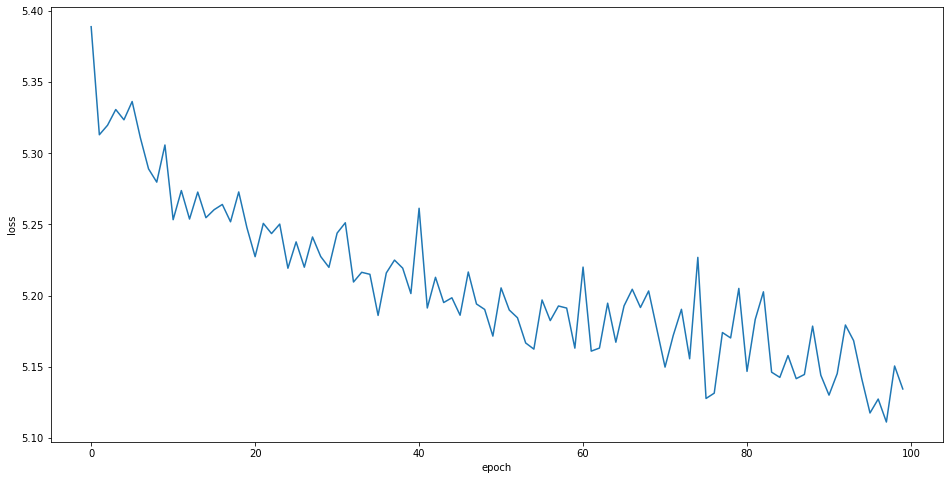

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

## Evaluate embeddings

In [37]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(455, 16)
(114, 16)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



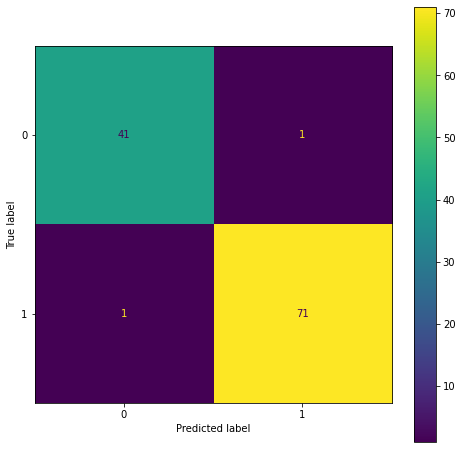

In [38]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

## # Visualzie using t-sne 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


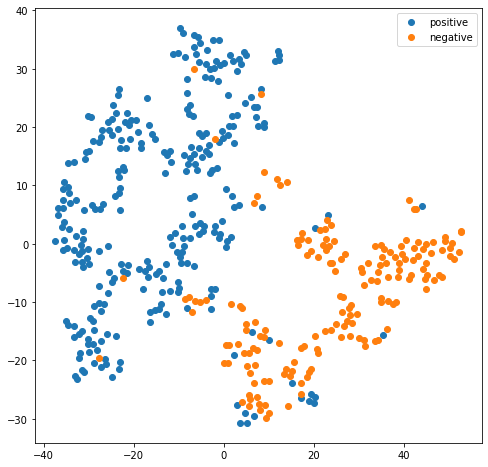

In [39]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()